# Predicting Hand Drawn Characters

#### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import string
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline 

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras import Model

from PIL import Image
import cv2
tf.__version__, cv2.__version__

('2.1.0', '4.2.0')

In [4]:
from emnist import list_datasets
from emnist import extract_training_samples, extract_test_samples

In [5]:
list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

### Load Data

In [6]:
X_train, train_labels = extract_training_samples('byclass')

In [7]:
X_train.shape, train_labels.shape

((697932, 28, 28), (697932,))

In [8]:
X_test, test_labels = extract_test_samples('byclass')

In [9]:
X_test.shape, test_labels.shape

((116323, 28, 28), (116323,))

(<matplotlib.image.AxesImage at 0x7fa7eb601358>, 32)

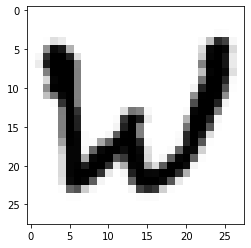

In [10]:
i = 300107
plt.imshow(X_train[i], cmap=plt.cm.binary), train_labels[i]

In [11]:
pd.Series(train_labels).value_counts().sort_index()

0     34585
1     38374
2     34203
3     35143
4     33535
      ...  
57     2910
58     2697
59     2822
60     2365
61     2725
Length: 62, dtype: int64

#### Remove Uppercase

In [12]:
def remove_upper(X_old, labels):
    nums = list(range(0, 10))
    upper = list(range(10, 36))
    lower = list(range(36, 62))
    X = []
    y = []
    for x, lab in zip(X_old, labels):
        if lab in nums:
            X.append(x)
            y.append(lab)
        elif lab in upper:
            continue
        elif lab in lower:
            lab -= 26
            X.append(x)
            y.append(lab)
    
    return np.array(X), np.array(y)

In [13]:
X_train, train_labels = remove_upper(X_train, train_labels)
X_test, test_labels = remove_upper(X_test, test_labels)

In [14]:
X_train.shape, train_labels.shape, X_test.shape, test_labels.shape

((508974, 28, 28), (508974,), (84977, 28, 28), (84977,))

#### Merge Train and Test

In [15]:
X = np.vstack((X_train, X_test))
labels = np.hstack((train_labels, test_labels))

In [16]:
X.shape, labels.shape

((593951, 28, 28), (593951,))

## Model

In [17]:
#chars = '0123456789' + string.ascii_uppercase + string.ascii_lowercase
chars = '0123456789' + string.ascii_lowercase

In [18]:
num_chars = len(chars) ; num_chars

36

In [19]:
X_train = X_train.reshape(-1, 28, 28, 1)

In [20]:
# 1-9: numbers
# 10-35: uppercase
# 36-61: lowercase

y_train = np.zeros((len(train_labels), num_chars))

for i, j in enumerate(train_labels):
    y_train[i, j] = 1

In [21]:
X_train.shape, y_train.shape, y_train.sum()

((508974, 28, 28, 1), (508974, 36), 508974.0)

In [22]:
X_test = X_test.reshape(-1, 28, 28, 1)

In [23]:
# 1-9: numbers
# 10-35: uppercase
# 36-61: lowercase

y_test = np.zeros((len(test_labels), num_chars))

for i, j in enumerate(test_labels):
    y_test[i, j] = 1

In [24]:
X_test.shape, y_test.shape, y_test.sum()

((84977, 28, 28, 1), (84977, 36), 84977.0)

In [25]:
# Model Outline
input_shape = (28, 28, 1)

# Input layer
imgm = Input(shape=input_shape)

# Convolution and Max Pooling layers
cn1 = Conv2D(32, (5,5), padding='same', activation='relu')(imgm)
mp1 = MaxPooling2D(padding='same')(cn1)  

cn2 = Conv2D(64, (5,5), padding='same', activation='relu')(mp1)
mp2 = MaxPooling2D(padding='same')(cn2)  

cn3 = Conv2D(32, (5,5), padding='same', activation='relu')(mp2)
mp3 = MaxPooling2D(padding='same')(cn3)   

cn4 = Conv2D(16, (5,5), padding='same', activation='relu')(mp3)
mp4 = MaxPooling2D(padding='same')(cn4)   

# Flatten and Dense layers
flat = Flatten()(mp4)
dens1 = Dense(128, activation='relu')(flat)
#drop = Dropout(0.5)(dens1)
bn = BatchNormalization()(dens1)
output = Dense(num_chars, activation='softmax')(bn)#(drop)


In [26]:
# Compile model
model = Model(imgm, output)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [27]:
model.summary();

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          51232     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0     

In [28]:
history = model.fit(X_train, train_labels, batch_size=256, epochs=10, verbose=2, validation_split=0.2)

Train on 407179 samples, validate on 101795 samples
Epoch 1/10
407179/407179 - 29s - loss: 0.3181 - accuracy: 0.9037 - val_loss: 0.2910 - val_accuracy: 0.9013
Epoch 2/10
407179/407179 - 27s - loss: 0.2044 - accuracy: 0.9295 - val_loss: 0.2207 - val_accuracy: 0.9266
Epoch 3/10
407179/407179 - 27s - loss: 0.1890 - accuracy: 0.9338 - val_loss: 0.2923 - val_accuracy: 0.9116
Epoch 4/10
407179/407179 - 27s - loss: 0.1794 - accuracy: 0.9361 - val_loss: 0.2004 - val_accuracy: 0.9314
Epoch 5/10
407179/407179 - 27s - loss: 0.1710 - accuracy: 0.9388 - val_loss: 0.2020 - val_accuracy: 0.9317
Epoch 6/10
407179/407179 - 27s - loss: 0.1644 - accuracy: 0.9406 - val_loss: 0.1963 - val_accuracy: 0.9319
Epoch 7/10
407179/407179 - 27s - loss: 0.1586 - accuracy: 0.9422 - val_loss: 0.1898 - val_accuracy: 0.9348
Epoch 8/10
407179/407179 - 27s - loss: 0.1529 - accuracy: 0.9437 - val_loss: 0.1947 - val_accuracy: 0.9346
Epoch 9/10
407179/407179 - 27s - loss: 0.1485 - accuracy: 0.9447 - val_loss: 0.1974 - val_ac

In [29]:
eval1 = model.evaluate(X_test, test_labels, verbose=2)

84977/84977 - 7s - loss: 0.2045 - accuracy: 0.9341


In [30]:
# 32/64/32 (5): loss: 0.1852 - accuracy: 0.9364
# 64/96/32 (5): loss: 0.1902 - accuracy: 0.9371

# 32/64/32/16 (5): loss: 0.1877 - accuracy: 0.9365

# filter size 5
# 84977/84977 - 7s - loss: 0.1908 - accuracy: 0.9372

#### Save Model

In [31]:
#model.save('draw_model.h5')

In [34]:
from tensorflow import keras
model = keras.models.load_model('../models/draw_model.h5')

In [35]:
def predict_test(X_test, labels):
    count = len(X_test)
    correct = 0
    all_preds = np.array(model.predict(X_test))
    
    for i, pr in enumerate(all_preds):
        
        if labels[i] == np.argmax(pr):
            correct += 1
        #c = chars[np.argmax(pr)]    
        elif np.argmax(pr) ==1 or np.argmax(pr)==21:
            correct +=1
        #else:
            #print(labels[i], np.argmax(pr))
            
    return (correct / count)

## Splitting Handwritten CAPTCHA

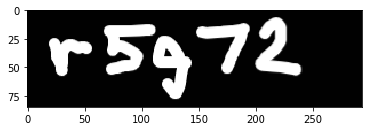

In [36]:
# example from 100,000 image dataset 
img=cv2.imread('../data/i_drew.png', cv2.IMREAD_UNCHANGED)[:,:,0]

plt.imshow(img, cmap=plt.cm.binary)

In [37]:
img.shape

(85, 293)

In [38]:
# remove background and flip color
flatimg = pd.Series(img.flatten()) 
flatimg = flatimg.apply(lambda x: 255 if x > 150 else x)
flatimg = flatimg.apply(lambda x: np.abs(x - 255))
img = flatimg.values.reshape(85,293)

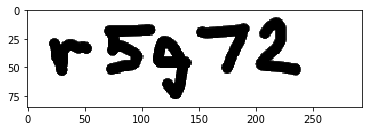

In [39]:
plt.imshow(img, cmap=plt.cm.binary)

In [40]:
img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

(37, 42)
(48, 49)
(59, 38)
(48, 51)
(55, 45)


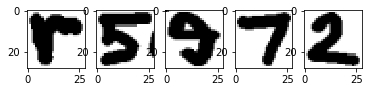

In [42]:
# Load the image and convert it to grayscale
image = cv2.imread('../data/i_drew.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Add some extra padding around the image
gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

# threshold the image (convert it to pure black and white)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

# find the contours (continuous blobs of pixels) the image
contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Hack for compatibility with different OpenCV versions
contours = contours[0] #if imutils.is_cv2() else contours[1]

letter_image_regions = []

# Now we can loop through each of the four contours and extract the letter
# inside of each one
for contour in contours:
    # Get the rectangle that contains the contour
    (x, y, w, h) = cv2.boundingRect(contour)

    # Compare the width and height of the contour to detect letters that
    # are conjoined into one chunk
    if w / h > 1.25:
        # This contour is too wide to be a single letter!
        # Split it in half into two letter regions!
        half_width = int(w / 2)
        letter_image_regions.append((x, y, half_width, h))
        letter_image_regions.append((x + half_width, y, half_width, h))
    else:
        # This is a normal letter by itself
        letter_image_regions.append((x, y, w, h))

        
# Sort the detected letter images based on the x coordinate to make sure
# we are processing them from left-to-right so we match the right image
# with the right letter
letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

fig, axs = plt.subplots(1,5)
axs = axs.flatten()
# Save out each letter as a single image
for i,letter_bounding_box in enumerate(letter_image_regions):   #, letter_text in zip( , captcha_correct_text):
    # Grab the coordinates of the letter in the image
    x, y, w, h = letter_bounding_box

    # Extract the letter from the original image with a 2-pixel margin around the edge
    letter_image = thresh[y - 2:y + h + 2, x - 2:x + w + 2]
    print(letter_image.shape)
    resized = cv2.resize(letter_image, (28,28), interpolation = cv2.INTER_AREA)
    
    #axs[i].imshow(letter_image, cmap=plt.cm.binary)
    axs[i].imshow(resized, cmap=plt.cm.binary)

## Function Testing

In [45]:
# function to split handwritten captcha
import os
import string
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import cv2

# function to split handwritten captcha
def split_drawn(drawn_img):
    thresh = drawn_img.copy()

    # find the contours (continuous blobs of pixels) the image
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    letter_image_regions = []

    # Iterate through the contours
    for contour in contours:
        # Find location of each character
        (x, y, w, h) = cv2.boundingRect(contour)

        """# If width/height is too large to be a one character, split it
        if w / h > 1.5:
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:"""
        letter_image_regions.append((x, y, w, h))

    # Sort the characters
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

    # Add each resized character to an array
    char_lst = []
    for i, letter_bounding_box in enumerate(letter_image_regions):
        # Get location of character
        x, y, w, h = letter_bounding_box

        # Extract the character
        letter_image = thresh[y - 2:y + h + 2, x - 2:x + w + 2]
        
        # Resize the character
        resized = cv2.resize(letter_image, (28,28), interpolation = cv2.INTER_AREA)
        resized = resized.reshape(28,28,1)

        char_lst.append(resized)
    
    return np.array(char_lst)

# function to predict drawn captcha
def predict_drawn(model, img):
    chars = '0123456789' + string.ascii_lowercase
    
    # split the drawn image
    split_img = split_drawn(img)
    
    # predict each character
    pred_arr = model.predict(split_img)
    
    pred = ''
    for i in pred_arr:
        c = chars[np.argmax(i)]
        pred += c

    return pred

In [53]:
# Load the image and convert it to grayscale
image = cv2.imread('../data/nolined.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Add some extra padding around the image
gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

# threshold the image (convert it to pure black and white)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

In [54]:
thresh.shape

(96, 285)

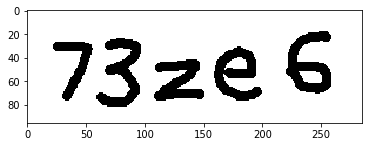

In [55]:
plt.imshow(thresh, cmap=plt.cm.binary)

## View Data


In [17]:
def remove_grid_lines(axs):
    """Remove the default grid lines from a collection of axies."""
    for ax in axs.flatten():
        ax.grid(False)
        ax.tick_params(axis='both', which='both', bottom=False, top=False, 
                       labelbottom=False, right=False, left=False, labelleft=False)

In [18]:
X.shape

(593951, 28, 28)

In [25]:
sevens = X[labels == 7]; sevens.shape

(41893, 28, 28)

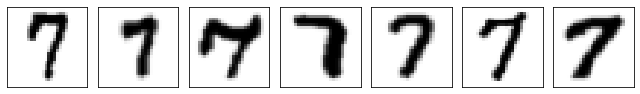

In [33]:
fig, axs = plt.subplots(1, 7, figsize=(9, 9))
for i, ax in zip([15,12,42,62,43,121,41412],axs.flatten()):
    #i += np.random.randint(100,100000)
    ax.imshow(sevens[i].reshape(28,28), cmap=plt.cm.binary)
    
remove_grid_lines(axs)
plt.tight_layout()
#plt.savefig('images/augmented.png')

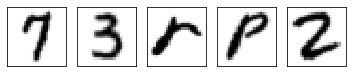

In [45]:
alst=[]
fig, axs = plt.subplots(1, 5, figsize=(5, 5))
for i, ax in zip([565528, 505709, 124408, 142454, 202618],axs.flatten()):
    #i += np.random.randint(100,100000)
    ax.imshow(X[i].reshape(28,28), cmap=plt.cm.binary)
    alst.append(i)
    
remove_grid_lines(axs)
plt.tight_layout()
#plt.savefig('images/augmented.png')

In [20]:
alst

[87556, 30129, 21648, 68237, 54081]

In [21]:
labels[19824]

14

In [22]:
def create_drawn_captcha(X, labels):
    chars = '0123456789' + string.ascii_lowercase
    img_lst = []
    choices_lst = []
    for i in range(10):
        # choose 5 random characters
        choices = np.random.randint(0, len(labels), 5)
        hwhite = np.zeros((28, 10))
        vwhite = np.zeros((5,160))
        a,b,c,d,e = (i for i in choices)

        # join the 5 characters together
        cat_img = np.concatenate((hwhite, X[a], X[b],X[c], X[d], X[e], hwhite), axis=1)
        cat_img = np.concatenate((vwhite, cat_img, vwhite), axis=0)
        cat_img = cv2.resize(cat_img, (200,50), interpolation = cv2.INTER_AREA)
        cat_img = cv2.threshold(cat_img, 40, 255, cv2.THRESH_BINARY)[1]

        # start and end points for the line
        points= np.random.randint(0, 49, 2)
        start_point = (0, points[0]) 
        end_point = (199, points[1]) 

        color = (255,255,255) 
        thickness = 2

        # Draw a diagonal black line on image
        img = cv2.line(cat_img, start_point, end_point, color, thickness, lineType=8) 
        
        img_lst.append(img)
        choices_lst.append(choices)
        
    fig, ax = plt.subplots(5,2, figsize=(15,8))
    ax = ax.flatten()
    for i, img in enumerate(img_lst):
        ax[i].imshow(img, cmap=plt.cm.binary)
    remove_grid_lines(ax)
    
    print(choices_lst)

In [56]:
labels[384682]

1

[array([239183, 205111, 384682, 391731, 347908]), array([195795,  54584, 315504, 483753, 493176]), array([540549, 422897, 523777, 374688, 406518]), array([239225, 208153, 459565,  28823, 593062]), array([509133,  52522, 441862, 430181, 579596]), array([284762, 412581, 167115, 589045,  64571]), array([ 44843, 106946,  50155, 592383,   3475]), array([133273, 411748, 269612, 459485,  46836]), array([565528, 505709, 124408, 142454, 202618]), array([538920, 431330, 495961,  53857, 335988])]


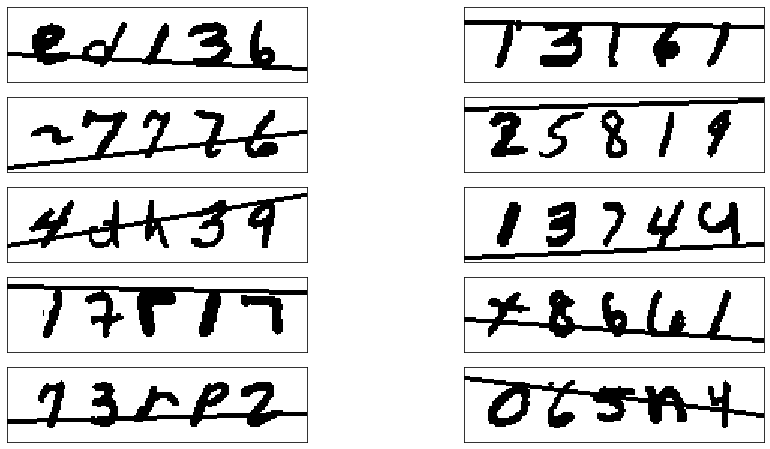

In [44]:
create_drawn_captcha(X, labels)

In [127]:
def load_labels(from_src=False):
    if from_src:
        path = '../data/drawn/'
    else:
        path = 'data/drawn/'
        
    leng = len(os.listdir(path))

    labels = []
    
    for i, name in enumerate(os.listdir(path)):
        
        label = name[:-4]

        labels.append(label)
   
    return np.array(labels)

In [128]:
allabels = load_labels(from_src=True)

In [129]:
allabels

array(['82j4e', '1d5yt', '4a8v9', ..., 'q6t0j', 'rar14', '025rh'],
      dtype='<U5')

In [130]:
lst_of_chars = []
for s in allabels:
    lst_of_chars += [char for char in s]
len(lst_of_chars)/len(allabels), len(lst_of_chars)

(5.0, 5066830)

In [131]:
pd.Series(lst_of_chars).value_counts()

1    351774
7    333975
3    329854
0    325265
2    323324
6    322883
9    320400
8    320006
4    317774
5    300754
e    246705
t    191493
l    163704
r    152528
n    127081
d    113324
a    112287
h     99564
b     60231
g     43775
q     36181
v     34504
u     34123
c     33947
x     33916
o     33370
z     32710
i     32595
w     32479
s     32268
m     32082
f     30767
k     30742
p     29137
y     28391
j     22917
dtype: int64

In [12]:
chars = '0123456789' + string.ascii_lowercase
num_chars = len(chars)

def data_check(from_src=False):
    '''Check for non PNG files
    '''
    if from_src:
        path = '../data/drawn/'
    else:
        path = 'data/drawn/'
        
    for name in os.listdir(path):
        if name[-4:] == '.png':
            pass
        else:
            print(name)
            
def mix_img(img, fill_val = 0):
    # random rotate value
    ang_list = [-5,-4,-3,-2,-1,0,0,0,0,0,1,2,3,4,5]
    ang = random.choice(ang_list)
    # rotate image
    im = Image.fromarray(img)
    img = np.asarray(im.rotate(ang))
    
    return img

def load_drawn_data(from_src=False):
    if from_src:
        path = '../data/drawn/'
    else:
        path = 'data/drawn/'
        
    leng = len(os.listdir(path))
        
    X = np.zeros((leng, 50, 200, 1)) 
    y = np.zeros((5, leng, num_chars)) 
    labels = []
    
    for i, name in enumerate(os.listdir(path)):
        
        if i == leng:
            break
            
        img_path = path + name
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        
        img = img / 255.0
        img = img.reshape(50, 200, 1)
        
        # Define labels using OneHotEncoding
        label = name[:-4]
        target = np.zeros((5, num_chars))
        for j, l in enumerate(label):
            ind = chars.find(l)
            target[j, ind] = 1
        
        X[i] = img
        y[:, i] = target
        labels.append(label)
   
    return X, y, np.array(labels)

In [13]:
data_check(from_src=True)

In [14]:
nX, ny, nlabels = load_drawn_data(from_src=True)

In [15]:
nX.shape, ny.shape, nlabels.shape

((750000, 50, 200, 1), (5, 750000, 36), (750000,))